# Variability analysis for HBEC IFN experiment

In [2]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [3]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/ifn_hbec/'

### Get canonical TFs

In [5]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [6]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [7]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [8]:
adata.shape

(69252, 36588)

### Read 1d HT result comparing to control

In [9]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [10]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [11]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Some basic enrichment analysis - increased variance

In [12]:
stim = 'gamma'
gene_list = []
for tp in tps[1:]:
    df = all_result['bc-basal']['ht'][stim][tp].query('dv_coef > 0 & dv_fdr < 0.1 & de_coef > 0')
    gene_list += df.gene.tolist()
gene_list = list(set(gene_list))

### Setup memento

In [13]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [14]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [15]:
memento.setup_memento(adata, q_column='q')

### Perform 2D testing with canonical TFs - genes with increased variance

In [16]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma']

In [17]:
condensed_tfs = []
for tf in tfs:
    if 'STAT' in tf:
        condensed_tfs.append(tf)
    elif 'IRF' in tf:
        condensed_tfs.append(tf)
    elif 'NFKB' in tf:
        condensed_tfs.append(tf)
    elif 'JUN' in tf:
        condensed_tfs.append(tf)
    elif 'MYC' in tf:
        condensed_tfs.append(tf)
    elif 'FOS' in tf:
        condensed_tfs.append(tf)
    else:
        continue

In [18]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/coex_test_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            gene_list = []
            for tp2 in tps[1:]:
                df = all_result['-'.join(ct)]['ht'][stim][tp2].query('dv_coef > 0 & dv_fdr < 0.1 & de_coef > 0')
                gene_list += df.gene.tolist()
            gene_list = list(set(gene_list))
            
            fname = '{}_{}_{}_incv.h5ad'.format('-'.join(ct), stim, tp)
            if fname in done_files:
                print('skipping', ct, tp, stim)
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            relevant_tfs = list(set(condensed_tfs) & set(adata_stim.var.index))
            filtered_gene_list = list(set(gene_list) & set(adata_stim.var.index))
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_gene_list)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_incv.csv'.format('-'.join(ct), stim, tp), index=False)

            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_gene_list)))

            memento.ht_2d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/coex_test_deep/{}_{}_{}_incv.h5ad'.format('-'.join(ct), stim, tp))

### 2D test for dec var genes

In [20]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/coex_test_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            gene_list = []
            for tp2 in tps[1:]:
                df = all_result['-'.join(ct)]['ht'][stim][tp2].query('dv_coef < 0 & dv_fdr < 0.1 & de_coef > 0')
                gene_list += df.gene.tolist()
            gene_list = list(set(gene_list))
            
            fname = '{}_{}_{}_decv.h5ad'.format('-'.join(ct), stim, tp)
            if fname in done_files:
                print('skipping', ct, tp, stim)
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            relevant_tfs = list(set(condensed_tfs) & set(adata_stim.var.index))
            filtered_gene_list = list(set(gene_list) & set(adata_stim.var.index))
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_gene_list)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp), index=False)

            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_gene_list)))

            memento.ht_2d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/coex_test_deep/{}_{}_{}_decv.h5ad'.format('-'.join(ct), stim, tp))

### Get the correlations

In [107]:
stim = 'gamma'
ct = ['bc-basal']

In [129]:
fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_incv.csv'.format('-'.join(ct), stim, tp)
tp = '3'
combined_incv = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})[['gene_1', 'gene_2','control', 'tp3']]
for tp in tps[1:]:
    fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_incv.csv'.format('-'.join(ct), stim, tp)
    df = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})
    combined_incv = combined_incv.merge(df[['gene_1', 'gene_2', 'tp'+tp]], on=['gene_1', 'gene_2'])

In [138]:
fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp)
tp = '3'
combined_decv = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})[['gene_1', 'gene_2','control', 'tp3']]
for tp in tps[1:]:
    fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp)
    df = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})
    combined_decv = combined_decv.merge(df[['gene_1', 'gene_2', 'tp'+tp]], on=['gene_1', 'gene_2'])

In [131]:
dc_tfs = list(set(combined_incv.gene_1.values) & set(combined_decv.gene_1.values))

In [116]:
len(dc_tfs)

17

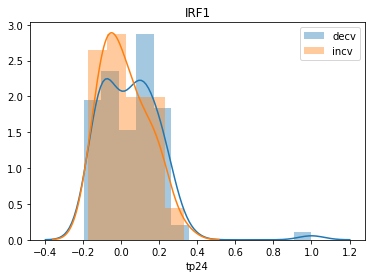

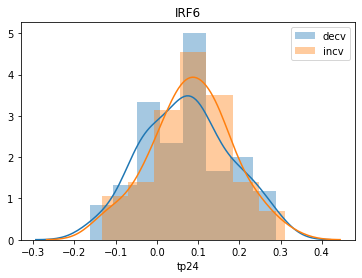

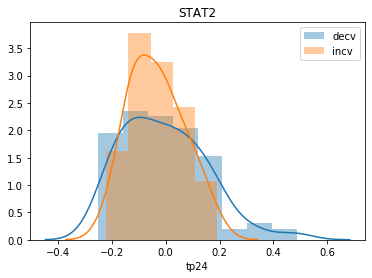

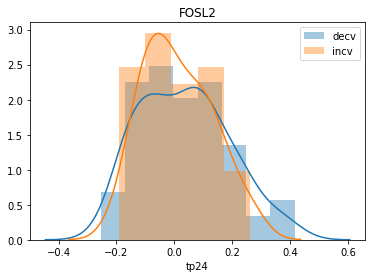

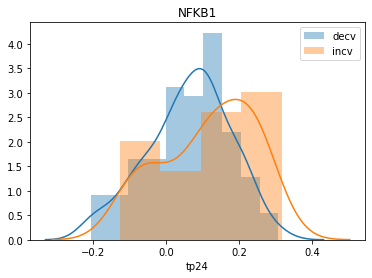

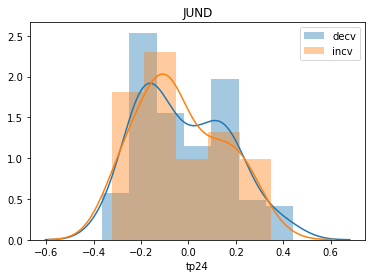

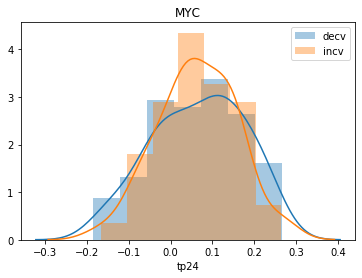

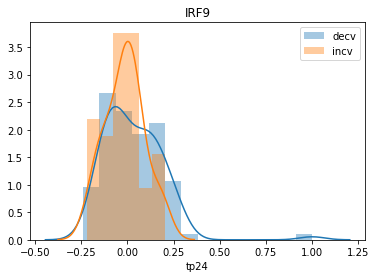

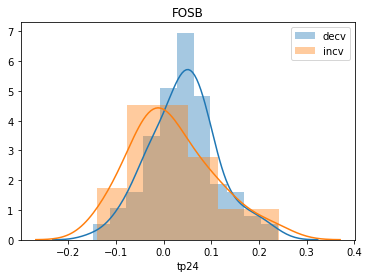

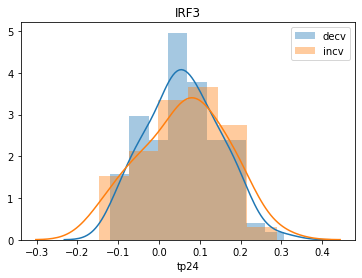

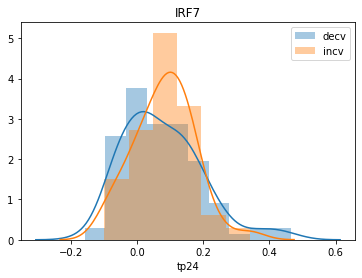

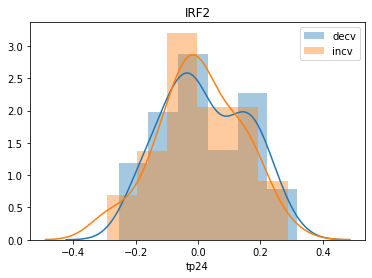

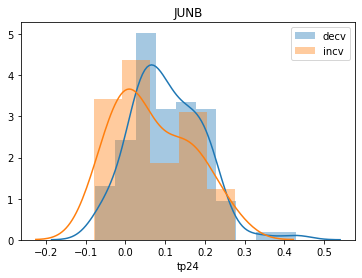

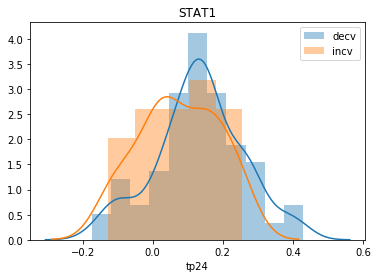

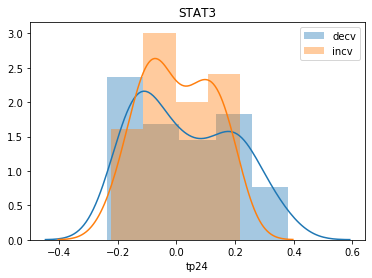

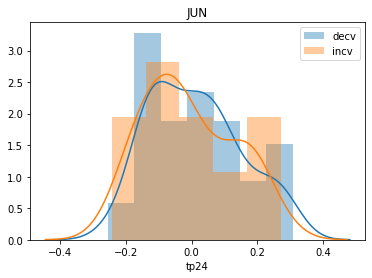

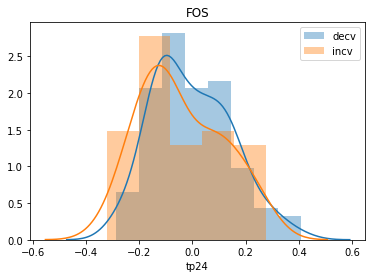

In [151]:
for tf in dc_tfs:
    plt.figure()
#     sns.distplot(combined_decv.query('gene_1 == "{}"'.format(tf)).iloc[:, 3:].values.reshape(-1), label='decv')
#     sns.distplot(combined_incv.query('gene_1 == "{}"'.format(tf)).iloc[:, 3:].values.reshape(-1), label='incv')

    sns.distplot(combined_decv.query('gene_1 == "{}"'.format(tf)).tp24, label='decv')
    sns.distplot(combined_incv.query('gene_1 == "{}"'.format(tf)).tp24, label='incv')
    plt.legend()
    plt.title(tf)


In [103]:
combined_incv

,gene_1,gene_2,control,tp3,tp48
0,IRF1,RPL39,-0.065292,-0.212490,-0.212490
1,IRF1,HLA-DRB1,0.023905,0.107089,0.107089
2,IRF1,IFI44L,0.437770,0.048242,0.048242
3,IRF1,SOCS3,0.085819,0.184960,0.184960
4,IRF1,PLAAT4,0.396816,0.150253,0.150253
...,...,...,...,...,...
1903,FOS,PSMB9,-0.003747,-0.016008,-0.016008
1904,FOS,F3,0.339649,0.197978,0.197978
1905,FOS,FGFBP1,-0.180859,-0.152833,-0.152833
1906,FOS,TXN,0.208298,0.097376,0.097376


### Analyze the 2D information - inc var

In [60]:
tp = '9'
stim = 'gamma'
ct = ['bc-basal']

In [71]:
fname = '/data_volume/ifn_hbec/coex_test_deep/{}_{}_{}_incv.h5ad'.format('-'.join(ct), stim, tp)

In [72]:
a = sc.read(fname)

In [73]:
df = memento.get_2d_ht_result(a)
df = df[~df['gene_2'].str.startswith('RP')].copy()
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

In [77]:
df.query('corr_fdr < 0.1 & corr_coef > 0').sort_values('corr_coef', ascending=False)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
391,IRF9,C4orf3,0.637691,0.213881,0.002800,0.070248
550,IRF7,CXCL10,0.591846,0.178180,0.001042,0.068837
324,MYC,PDLIM4,0.414590,0.139667,0.002600,0.070248
598,JUNB,SLC2A1,0.382446,0.091964,0.001081,0.068837
627,JUNB,HSP90AB1,0.294077,0.070590,0.000758,0.062725
640,JUNB,ENO1,0.269102,0.079693,0.001837,0.070248
638,JUNB,TXNDC17,0.265410,0.063775,0.000646,0.059454
633,JUNB,GAPDH,0.265254,0.054053,0.000482,0.057199
632,JUNB,MIF,0.256217,0.053341,0.002160,0.070248
622,JUNB,EIF4A1,0.233304,0.079349,0.004200,0.089001


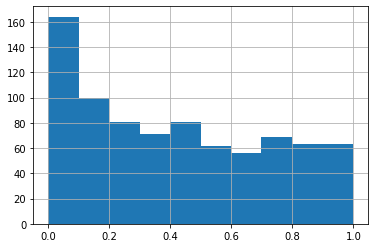

In [33]:
df.corr_pval.hist()